# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import re

import matplotlib.pyplot as plt
%matplotlib inline  

# Загружаем данные

## Мне только посмотреть

Это соревнование - продолжение одного из предыдущих.
Данные для этого соревнования уже чистые, поэтому будем обрабатывать train и test одновременно.

In [2]:
data = pd.concat([pd.read_csv('train.csv').assign(source='train'), 
                  pd.read_csv('test.csv').assign(source='test'),
                 ], axis=0, ignore_index=True)
data['price'] = data['price'].fillna(0.0)

In [3]:
data.sample(3).T

,3509,58,869
bodyType,седан,седан,внедорожник 5 дв.
brand,AUDI,BMW,AUDI
color,чёрный,чёрный,серый
description,"Пробег 180000 реальный,машина полностью обслуж...","Продаётся BMW 525 d xdrive, два ключа. Я собст...",Привезён 3-х летним из Германии. В России я ед...
engineDisplacement,4.2 LTR,2.0 LTR,3.0 LTR
enginePower,350 N12,218 N12,238 N12
fuelType,бензин,дизель,дизель
mileage,180000,119458,255000
modelDate,2005,2013,2009
model_info,A8,5ER,Q7


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   object 
 5   enginePower           8353 non-null   object 
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   int64  
 8   modelDate             8353 non-null   int64  
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   int64  
 12  price                 8353 non-null   float64
 13  productionDate        8353 non-null   int64  
 14  sell_id               8353 non-null   int64  
 15  vehicleConfiguration 

In [5]:
# пропуски есть по владельцам и срокам владения

## Слегка причешем

In [6]:
# приведём названия признаков к единому стилю
rule_rename = {'bodyType': 'body_type',
               'engineDisplacement': 'engine_displacement',
               'enginePower': 'engine_power',
               'fuelType': 'fuel_type',
               'modelDate': 'model_year',
               'model': 'model_name',
               'numberOfDoors': 'n_doors',
               'productionDate': 'production_year',
               'vehicleConfiguration': 'vehicle_configuration',
               'vehicleTransmission': 'vehicle_transmission',
               'Владельцы': 'n_owners',
               'Владение': 'time_ownership',
               'ПТС': 'vehicle_passport',
               'Привод': 'drive_type',
               'Руль': 'wheel',
              }
data.rename(columns=rule_rename, inplace=True)

In [7]:
# мощность двигателя сделаем числом
data['engine_power'] = (data['engine_power']
                        .str.replace(' N12', '')  # не знаю, что за единица измерения, но л.с. по смыслу
                        .astype('int')
                       )

In [8]:
# объем двигателя сделаем числом
data['engine_displacement'] = (data['engine_displacement']
                               .str.replace('undefined', '0.0')  # электрички
                               .str.replace(' LTR', '')
                               .astype('float')
                              )

## И посмотрим повнимательнее

5    3854
4    3636
2     802
3      61
Name: n_doors, dtype: int64

<AxesSubplot:>

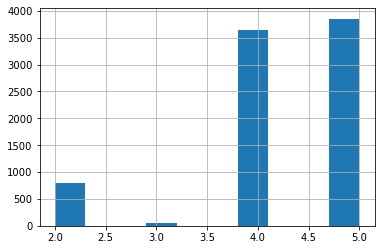

In [9]:
# pandas profiling спотыкается на n_doors
display(data['n_doors'].value_counts())
data['n_doors'].hist()

In [10]:
data_4profile = data.drop(columns=['n_doors', 
                                   'description',
                                   'name',
                                   'sell_id',
                                   'vehicle_configuration',
                                   'time_ownership',
                                  ])
data_profile = ProfileReport(data_4profile, title="Train dataset profile")

In [11]:
# data_profile.to_notebook_iframe()

Цена сильнее всего зависит от пробега и года.

? Год модели и год выпуска коррелируют, оставим только год выпуска.

? Мощность и объем двигателя коррелируют, оставим только мощность.



# Подготовка данных

## Копируем основу

In [12]:
# удалим требующие обработки и сильно скоррелированные
data_1 = data.drop(columns=['vehicle_passport',       # сделаем новый
                            'wheel',                  # сделаем новый
#                             'brand',                  # будет частью другого
                            'model_info',             # будет частью другого
                            'name',                   # все данные уже есть в других
                            'vehicle_configuration',  # все данные уже есть в других
                        #     'body_type', 
                        #     'color', 
                        #     'description', 
                        #     'engine_displacement',
                        #     'engine_power', 
                        #     'fuel_type', 
                        #     'mileage', 
                        #     'model_year', 
                        #     'n_doors', 
                        #     'price', 
                        #     'production_year', 
                        #     'sell_id',
                        #     'vehicle_transmission', 
                        #     'n_owners',
                        #     'time_ownership', 
                        #     'drive_type', 
                           ])

## Простые обработки признаков

In [13]:
# ПТС - это бинарный признак, оригинал или дубликат
data_1['is_original_techpass'] = data['vehicle_passport'].apply(lambda x: 1 if x.lower() in ['original', 'оригинал'] else 0).astype('int8')

In [14]:
# Руль - это бинарный признак, левый или правый
data_1['is_lefthand_drive'] = data['wheel'].apply(lambda x: 1 if x.lower() in ['left', 'левый'] else 0).astype('int8')

In [15]:
# сделаем объем двигателя числом
# engine_displacement_re = data_raw['name'].apply(lambda x : re.match('\d\.\d', x))
# data_1['engine_displacement'] = engine_displacement_re.apply(lambda x: float(x.group(0)) if x is not None else np.NaN)

In [16]:
# укрупним категории типа кузова
body_type = {'лифтбек': 'лифтбек',
             'фастбек': 'лифтбек',
             'седан': 'седан',
             'внедорожник': 'внедорожник',
             'хэтчбек': 'хэтчбек',
             'универсал': 'универсал',
             'пикап': 'пикап',
             'купе': 'купе',
             'кабриолет': 'кабриолет',
             'родстер': 'родстер',
             'тарга': 'родстер',
             'вэн': 'минивэн',
             'лимузин': 'лимузин',
             'фургон': 'фургон',
            }

def generic_body_type(raw_body_type):
    """
    Функция ищет ключевые слова в описании кузова и возвращает тип кузова
    """
    result = raw_body_type
    for keyword in body_type.keys():
        if raw_body_type.lower().find(keyword) >= 0:
            result = body_type[keyword]
            break
    return result

data_1['body_type'] = data_1['body_type'].fillna(value='unknown').apply(generic_body_type)
data_1['body_type'].unique()

array(['седан', 'лифтбек', 'внедорожник', 'хэтчбек', 'минивэн',
       'универсал', 'купе', 'кабриолет', 'родстер', 'пикап', 'лимузин'],
      dtype=object)

In [17]:
# назовём количество владельцев
owners = {'1': '1',
          '2': '2',
          '3': '3+',
         }

def generic_owners(raw_owners):
    """
    Функция даёт название КПП
    """
    result = str(raw_owners)
    for keyword in owners.keys():
        if str(raw_owners).find(keyword) >= 0:
            result = owners[keyword]
            break
    return result

data_1['n_owners'] = data_1['n_owners'].fillna(value='0').apply(generic_owners)
data_1['n_owners'].unique()

array(['3+', '2', '1', '0'], dtype=object)

## Более сложные признаки

In [18]:
# соберём марку и модель в один признак
data_1['full_model_name'] = (data['brand'] + ' ' + data['model_info']).str.lower()
np.sort(data_1['full_model_name'].unique())

array(['audi 100', 'audi a1', 'audi a3', 'audi a4', 'audi a4_allroad',
       'audi a5', 'audi a6', 'audi a7', 'audi a8', 'audi allroad',
       'audi coupe', 'audi q3', 'audi q5', 'audi q7', 'audi q8',
       'audi r8', 'audi rs3', 'audi rs4', 'audi rs5', 'audi rs6',
       'audi rs7', 'audi rsq3', 'audi s3', 'audi s4', 'audi s5',
       'audi s6', 'audi s7', 'audi s8', 'audi sq5', 'audi sq7', 'audi tt',
       'audi tts', 'bmw 1er', 'bmw 2activetourer', 'bmw 2er',
       'bmw 2grandtourer', 'bmw 3er', 'bmw 4', 'bmw 5er', 'bmw 6er',
       'bmw 7er', 'bmw 8er', 'bmw i3', 'bmw i8', 'bmw m1', 'bmw m2',
       'bmw m3', 'bmw m4', 'bmw m5', 'bmw m6', 'bmw x1', 'bmw x2',
       'bmw x3', 'bmw x3_m', 'bmw x4', 'bmw x4_m', 'bmw x5', 'bmw x5_m',
       'bmw x6', 'bmw x6_m', 'bmw x7', 'bmw z1', 'bmw z3', 'bmw z3m',
       'bmw z4', 'bmw z8', 'mercedes a_klasse', 'mercedes a_klasse_amg',
       'mercedes amg_glc_coupe', 'mercedes amg_gt', 'mercedes b_klasse',
       'mercedes c_klasse', 'merced

# Посмотрим на результат предобработки

In [19]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   body_type             8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engine_displacement   8353 non-null   float64
 5   engine_power          8353 non-null   int32  
 6   fuel_type             8353 non-null   object 
 7   mileage               8353 non-null   int64  
 8   model_year            8353 non-null   int64  
 9   n_doors               8353 non-null   int64  
 10  price                 8353 non-null   float64
 11  production_year       8353 non-null   int64  
 12  sell_id               8353 non-null   int64  
 13  vehicle_transmission  8353 non-null   object 
 14  n_owners              8353 non-null   object 
 15  time_ownership       

In [20]:
data_1_profile = ProfileReport(data_1, title="Data_EDA_v1 Profiling Report")
# data_1_profile.to_notebook_iframe()

# Сохраним результат предобработки

In [21]:
for src in data_1['source'].unique():
    (data_1
     .query(f'source == "{src}"')
     .drop(columns=['source'])
     .to_csv(f'{src}_preprocessed.csv', index=False)
    )

# Посмотрим внимательно на цены

In [22]:
data_1['price'].sample(10)

8038          0.0
1784    1545000.0
5022    3299000.0
488      799000.0
6476    1365000.0
8288          0.0
5482     900000.0
5509    2790000.0
7666          0.0
4535    4829000.0
Name: price, dtype: float64

In [23]:
# гипотеза - все цены кратны 1000 рублей
price = data_1['price']

In [24]:
(((price/1000).astype('int')*1000 - price) != 0).sum()
# довольно мало не кратны 1000

277

In [25]:
price[((price/1000).astype('int')*1000 - price) != 0]
# при этом даже не кратные, очень близки
# значит на постпроцессинге округлим стоимость до 1000

13       773999.0
59      6577900.0
69      8239821.0
108     7605250.0
126      999999.0
          ...    
6622    4399999.0
6638    1555555.0
6646    3127700.0
6654     698900.0
6675    1179221.0
Name: price, Length: 277, dtype: float64